In [2]:
# ANN classification on MNIST dataset
# loading libraries
import sys
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from keras.models import Model
import keras
from tqdm import tqdm
from keras.callbacks import Callback
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l2


In [3]:
# function to load dataset from keras
def load_dataset(name):
    # load dataset
    (trainX, trainY), (testX, testY) = name.load_data()
    # shape of dataset
    train_shape, test_shape = [trainX.shape, trainY.shape], [testX.shape, testY.shape]
    num_classes = len(np.unique(trainY))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY, train_shape, test_shape

In [4]:
trainX, trainY, testX, testY, train_shape, test_shape = load_dataset(mnist)

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
# processing the data
def data_process(trainX, testX):
    # convert from integers to floats
    trainX = trainX.astype('float32')
    testX = testX.astype('float32')
    # normalize to range 0-1
    trainX = trainX / 255.0
    testX = testX / 255.0
    trainX = trainX.reshape((len(trainX), np.prod(trainX.shape[1:])))
    testX = testX.reshape((len(testX), np.prod(testX.shape[1:])))
    # return normalized images
    return trainX, testX

In [6]:
trainX, testX = data_process(trainX, testX)
print(trainX.shape)

(60000, 784)


In [7]:
# The MNIST data is split between 60,000 training images and 10,000 test image
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


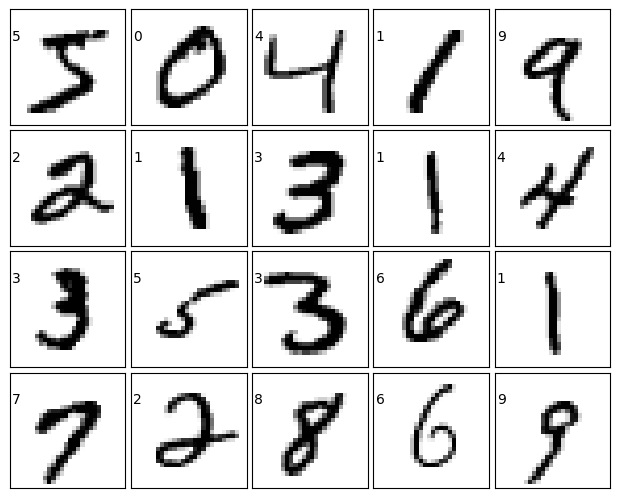

In [8]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(20):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y_train[i]))

In [9]:
# Reshaping the dataset
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# Change integers to 32-bit floating point numbers
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [10]:
# Apply standarization to both train and test data
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [11]:
# initializing the pca
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=.95)
pca.fit(X_train)

PCA(n_components=0.95)

In [ ]:
pca1 = PCA(n_components=.60)
pca1.fit(X_train)

PCA(n_components=0.6)

In [13]:
pca2=PCA(n_components=.24)
pca2.fit(X_train)

PCA(n_components=0.24)

In [14]:
print(f'Total number of components used after PCA : {pca2.n_components_}')

Total number of components used after PCA : 8


In [ ]:
print(f'Total number of components used after PCA : {pca1.n_components_}')

Total number of components used after PCA : 64


In [ ]:
print(f'Total number of components used after PCA : {pca.n_components_}')

Total number of components used after PCA : 331


In [ ]:
train_img = pca.transform(X_train)
test_img = pca.transform(X_test)

print(f'train_img shape : {train_img.shape}')
print(f'test_img shape : {test_img.shape}')

train_img shape : (60000, 331)
test_img shape : (10000, 331)


In [ ]:
train_img1 = pca1.transform(X_train)
test_img1 = pca1.transform(X_test)

print(f'train_img shape : {train_img1.shape}')
print(f'test_img shape : {test_img1.shape}')

train_img shape : (60000, 64)
test_img shape : (10000, 64)


In [ ]:
# diagnostic plots
def diagnostic_plots(history):
    # plot for loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='red', label='train')
    plt.plot(history.history['val_loss'], color='blue', label='test')
    plt.legend()
    # plot for accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='red', label='train')
    plt.plot(history.history['val_accuracy'], color='blue', label='test')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# ann model architecture
def define_model(input_size):
    # define model
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', input_dim=input_size, kernel_regularizer=l2(0.01)))
    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
class tqdm_cb(Callback):
    def __init__(self, total):
        super().__init__()
        self.total = total
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.total, desc='Training model')

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(loss=logs['loss'], accuracy=logs['accuracy'])

    def on_train_end(self, logs=None):
        self.pbar.close()

def run_test_harness(n_components):
    # load dataset
    trainX, trainY, testX, testY, train_shape, test_shape = load_dataset(mnist)
    # process data
    trainX, testX = data_process(trainX, testX)
    # performing PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    train_img = pca.transform(X_train)
    test_img = pca.transform(X_test)
    encoded_imgs_train = train_img
    encoded_imgs_test = test_img
    input_size = encoded_imgs_train.shape[1]
    # define model
    model = define_model(input_size)
    history = model.fit(encoded_imgs_train, trainY, epochs=100, batch_size=64, validation_data=(encoded_imgs_test, testY), verbose=0, callbacks=[tqdm_cb(100)])
    # evaluate model
    _, acc = model.evaluate(encoded_imgs_test, testY, verbose=0)
    print('> Accuracy: %.3f' % (acc * 100.0))
    diagnostic_plots(history)

Training model: 100%|██████████| 100/100 [04:53<00:00,  2.94s/it, accuracy=0.888, loss=0.346]


> Accuracy: 88.310


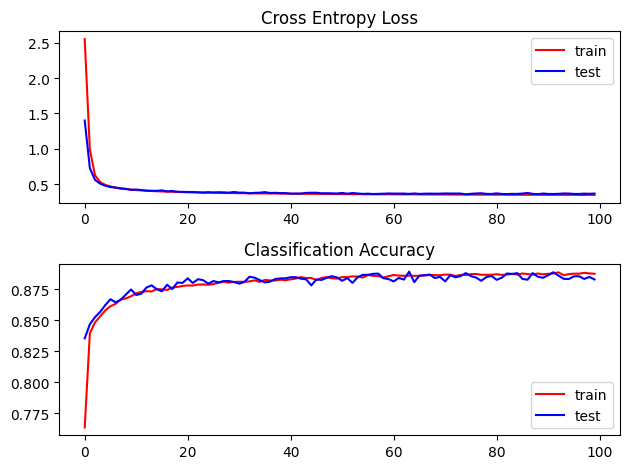

In [ ]:
run_test_harness(0.24)

Training model: 100%|██████████| 100/100 [04:54<00:00,  2.95s/it, accuracy=0.975, loss=0.151]


> Accuracy: 96.900


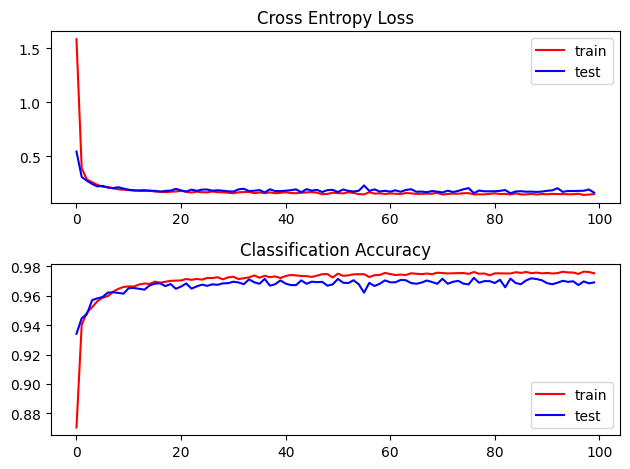

In [ ]:
run_test_harness(0.60)

Training model: 100%|██████████| 100/100 [04:54<00:00,  2.94s/it, accuracy=0.974, loss=0.226]


> Accuracy: 96.940


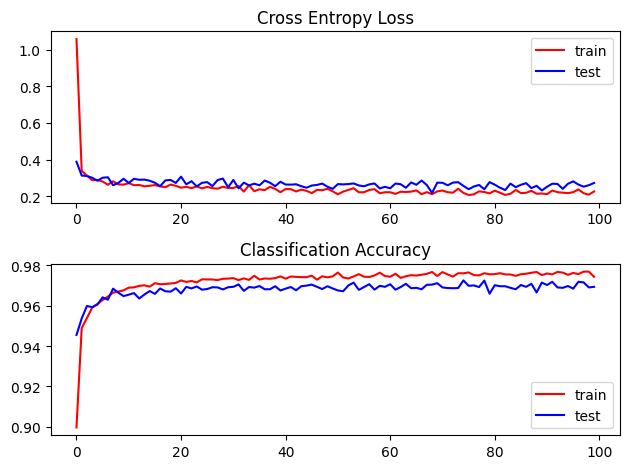

In [ ]:
run_test_harness(0.95)